In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
nba_data = pd.read_csv('nba_21features.csv')

# Display the first few rows of the DataFrame
nba_data.head()

,game_id,Game Date,Home Days Since Last Game,Home Games Last 7 Days,Home Is Back-to-Back,Away Days Since Last Game,Away Games Last 7 Days,Away Is Back-to-Back,Away Team Recent 10 Win Rate,Home Team Recent 10 Win Rate,...,home_ast_avg_last10,home_plus_minus_avg_last10,away_pts_avg_last10,away_reb_avg_last10,away_ast_avg_last10,away_plus_minus_avg_last10,target,home_injury_count,away_injury_count,is_playoffs
0,29900423,2000-01-02,5.0,1,False,3.0,1,False,0.4,0.7,...,24.7,-0.6,102.2,45.4,20.0,2.4,1.0,0,0,False
1,29900427,2000-01-03,5.0,2,False,5.0,1,False,0.6,0.4,...,19.1,-0.5,103.9,42.6,21.7,4.5,0.0,0,0,False
2,29900426,2000-01-03,4.0,1,False,8.0,0,False,0.8,0.4,...,21.8,-0.5,97.1,43.0,24.4,-3.3,1.0,0,0,False
3,29900429,2000-01-03,5.0,2,False,11.0,0,False,0.7,0.8,...,24.3,6.7,100.5,46.1,22.1,2.7,1.0,0,0,False
4,29900428,2000-01-03,5.0,2,False,13.0,0,False,0.3,0.2,...,19.5,-14.4,96.6,44.8,24.4,6.1,0.0,0,0,False


In [2]:
from sklearn.model_selection import train_test_split

X = nba_data.drop(columns=['game_id', 'Game Date', 'target'])
y = nba_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23072, 21), (5768, 21), (23072,), (5768,))

In [17]:
from sklearn.metrics import accuracy_score

# 计算测试集中多数类的比例作为baseline

# 找到测试集中多数类
majority_class = y_test_binary.mean() > 0.5  # 如果多数为1，则为True，否则为False
baseline_predictions = np.full_like(y_test_binary, majority_class, dtype=int)

# 计算baseline的准确率
baseline_accuracy = accuracy_score(y_test_binary, baseline_predictions)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline Accuracy: 0.5902


In [3]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.impute import SimpleImputer

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Convert regression output to binary classification
y_train_binary = np.where(y_train > 0.5, 1, 0)
y_test_binary = np.where(y_test > 0.5, 1, 0)

# Train a logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train_binary)

# Predict on the test set
y_pred = lr.predict(X_test)

print(classification_report(y_test_binary, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.41      0.48      2364
           1       0.66      0.81      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.63      0.61      0.61      5768
weighted avg       0.64      0.65      0.63      5768



C:\Users\fanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


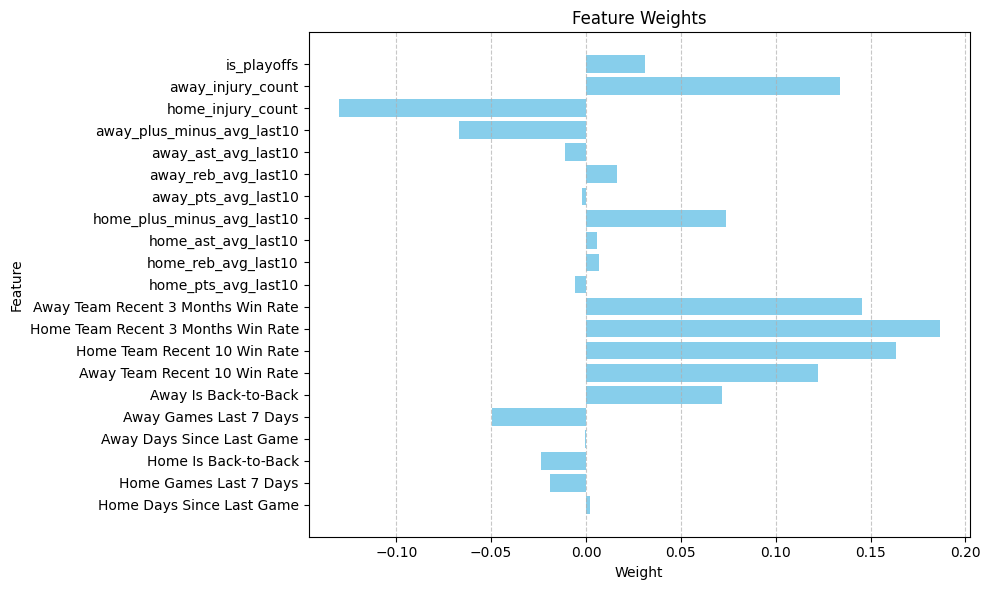

In [4]:
import matplotlib.pyplot as plt

# 获取特征名称和对应的权重
feature_names = X_train.columns
weights = lr.coef_.flatten()  # 将权重展平为1D数组

# 可视化权重
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Weights')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 使用GridSearchCV寻找最佳alpha值
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# 使用最佳参数训练Lasso模型
best_alpha = grid_search.best_params_['alpha']
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_lasso = lasso.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred_lasso)

print(f"Best alpha: {best_alpha}")

y_pred_lasso_binary = np.where(y_pred_lasso > 0.5, 1, 0)
print(classification_report(y_test_binary, y_pred_lasso_binary))

Best alpha: 0.0001
              precision    recall  f1-score   support

           0       0.61      0.43      0.50      2364
           1       0.67      0.81      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.65      0.65      0.64      5768



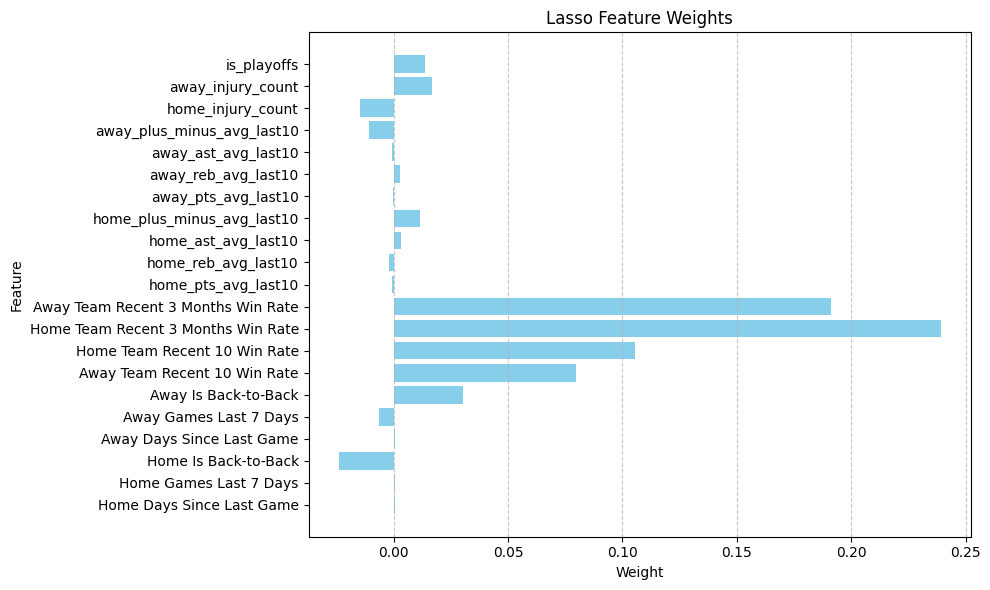

In [6]:
# 获取特征名称和对应的权重
feature_names = X_train.columns
weights = lasso.coef_  # 获取Lasso模型的权重

# 可视化权重
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Lasso Feature Weights')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.linear_model import Ridge

# 使用GridSearchCV寻找最佳alpha值
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_ridge = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge.fit(X_train, y_train)

# 使用最佳参数训练Ridge模型
best_alpha_ridge = grid_search_ridge.best_params_['alpha']
ridge = Ridge(alpha=best_alpha_ridge)
ridge.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_ridge = ridge.predict(X_test)

# 计算均方误差
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Best alpha for Ridge: {best_alpha_ridge}")

y_pred_ridge_binary = np.where(y_pred_ridge > 0.5, 1, 0)
print(classification_report(y_test_binary, y_pred_ridge_binary))

Best alpha for Ridge: 10
              precision    recall  f1-score   support

           0       0.61      0.43      0.51      2364
           1       0.67      0.81      0.74      3404

    accuracy                           0.66      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.65      0.66      0.64      5768



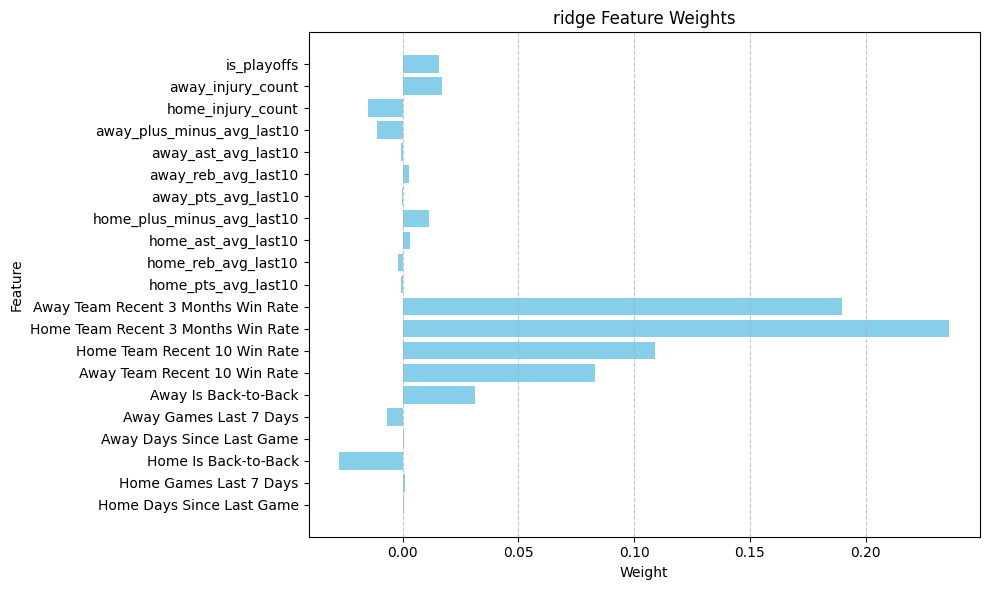

In [8]:
# 获取特征名称和对应的权重
feature_names = X_train.columns
weights = ridge.coef_  

# 可视化权重
plt.figure(figsize=(10, 6))
plt.barh(feature_names, weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('ridge Feature Weights')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)

# 在测试集上进行预测
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# 输出分类报告
print(classification_report(y_test_binary, y_pred_xgb))

C:\Users\fanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:32:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\fanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:32:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\fanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:32:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are

Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.61      0.45      0.52      2364
           1       0.68      0.80      0.73      3404

    accuracy                           0.66      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.65      0.66      0.64      5768



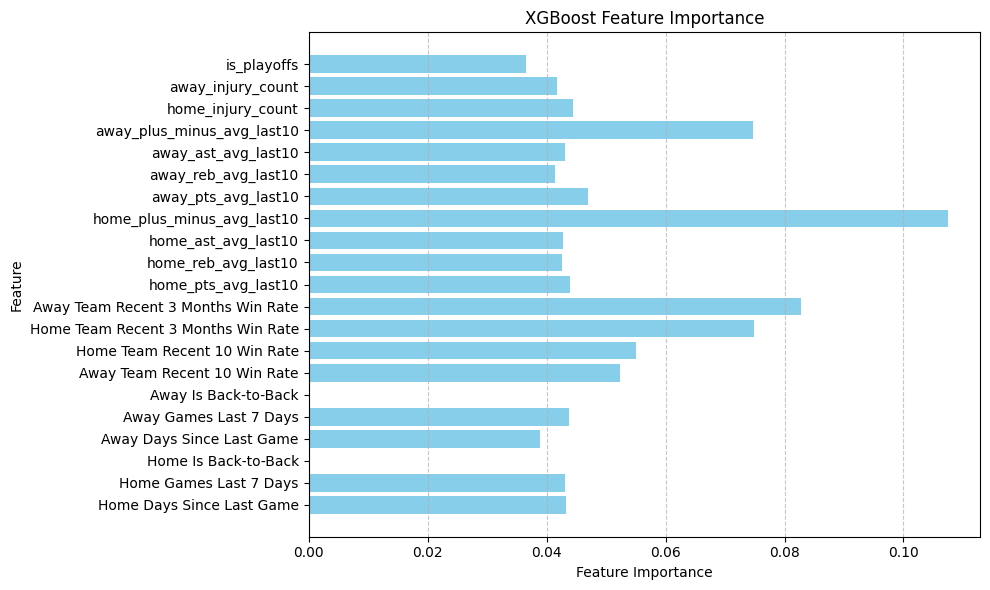

In [10]:
# 提取特征重要性
xgb_feature_importance = xgb_model.feature_importances_

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(feature_names, xgb_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# 创建LightGBM分类器
lgbm_model = LGBMClassifier()

# 训练模型
lgbm_model.fit(X_train, y_train_binary)

# 在测试集上进行预测
y_pred_lgbm = lgbm_model.predict(X_test)

# 输出分类报告
print(classification_report(y_test_binary, y_pred_lgbm))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13649, number of negative: 9423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2474
[LightGBM] [Info] Number of data points in the train set: 23072, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.591583 -> initscore=0.370513
[LightGBM] [Info] Start training from score 0.370513
              precision    recall  f1-score   support

           0       0.59      0.44      0.50      2364
           1       0.67      0.79      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.63      0.61      0.61      5768
weighted avg       0.64      0.65      0.63      5768



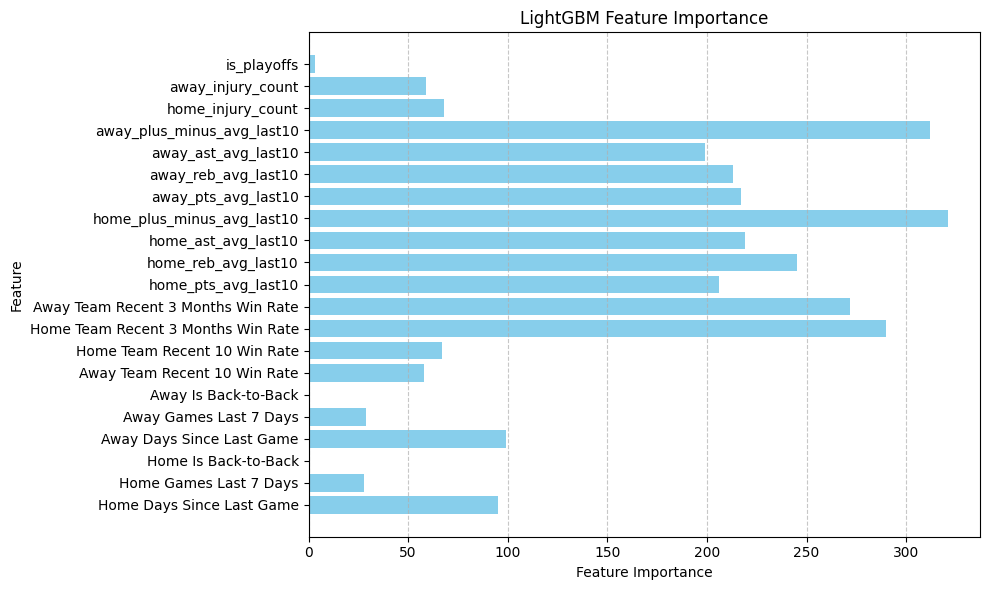

In [12]:
# 提取特征重要性
lgbm_feature_importance = lgbm_model.feature_importances_

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(feature_names, lgbm_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
# 定义参数网格
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

# 使用GridSearchCV寻找最佳参数
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, scoring='accuracy', cv=5)
grid_search_rf.fit(X_train, y_train_binary)

# 使用最佳参数训练随机森林分类器
best_rf_model = grid_search_rf.best_estimator_

# 在测试集上进行预测
y_pred_rf = best_rf_model.predict(X_test)

# 输出分类报告
print(classification_report(y_test_binary, y_pred_rf))

              precision    recall  f1-score   support

           0       0.61      0.42      0.50      2364
           1       0.67      0.82      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.65      0.65      0.64      5768



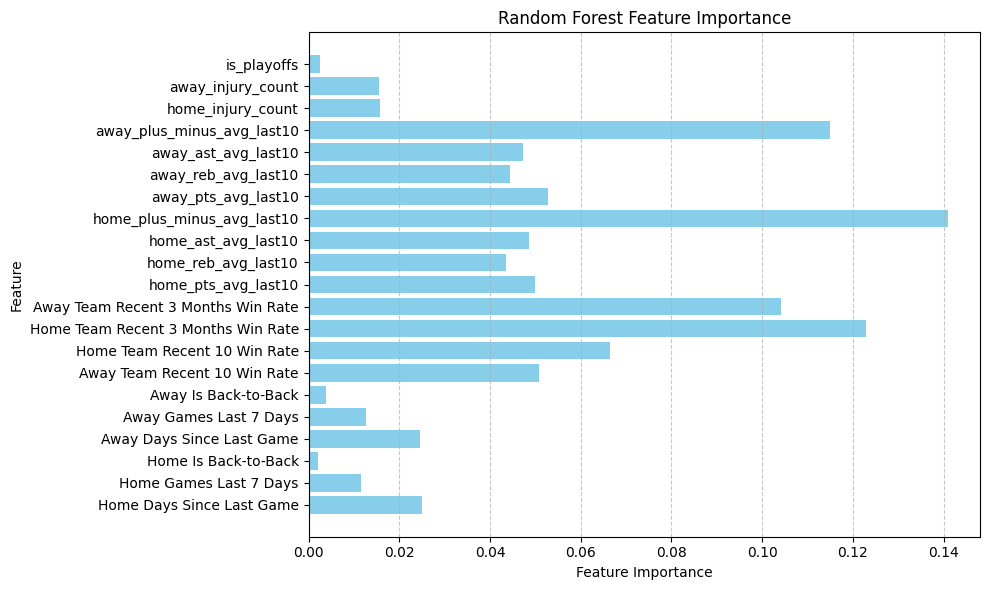

In [37]:
# 提取特征名称和对应的特征重要性
feature_importances = best_rf_model.feature_importances_

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 定义参数网格
param_grid_gb = {
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 5, 7]
}

# 使用GridSearchCV寻找最佳参数
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, scoring='accuracy', cv=5)
grid_search_gb.fit(X_train, y_train_binary)

# 使用最佳参数训练Gradient Boosting分类器
best_gb_model = grid_search_gb.best_estimator_

# 在测试集上进行预测
y_pred_gb = best_gb_model.predict(X_test)

# 输出分类报告
print(f"Best parameters: {grid_search_gb.best_params_}")
print(classification_report(y_test_binary, y_pred_gb))

Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.60      0.44      0.51      2364
           1       0.67      0.80      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.64      0.65      0.64      5768



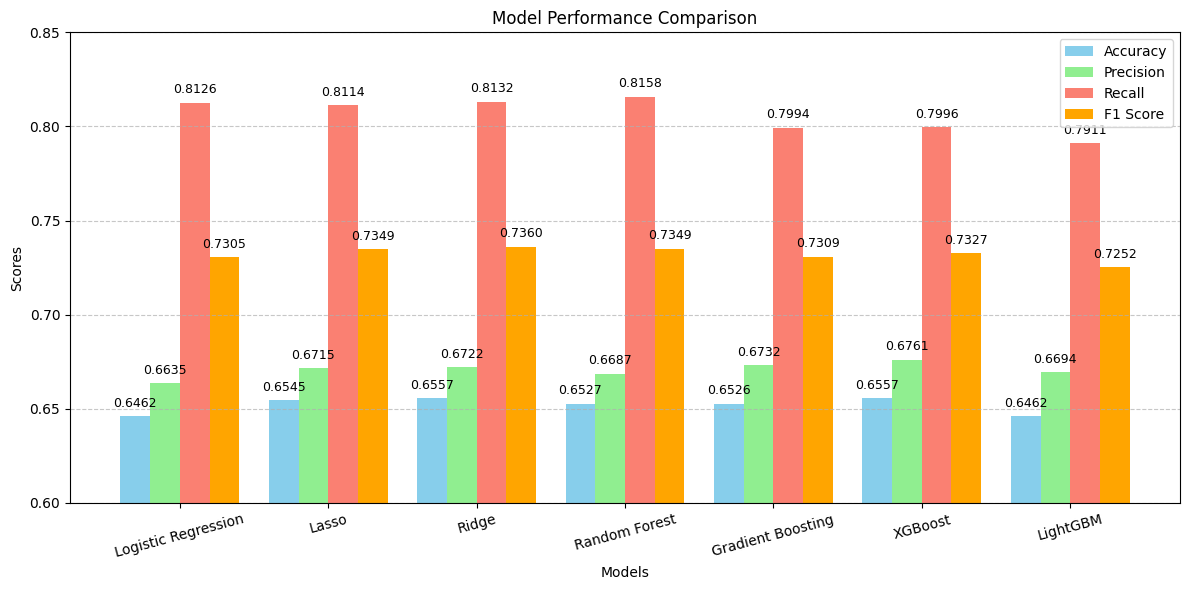

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

# 定义模型名称和预测结果
models = ['Logistic Regression', 'Lasso', 'Ridge', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
predictions = [y_pred, y_pred_lasso_binary, y_pred_ridge_binary, y_pred_rf, y_pred_gb, y_pred_xgb, y_pred_lgbm]

# 计算每个模型的指标
accuracies = [accuracy_score(y_test_binary, pred) for pred in predictions]
precisions = [precision_score(y_test_binary, pred) for pred in predictions]
recalls = [recall_score(y_test_binary, pred) for pred in predictions]
f1_scores = [f1_score(y_test_binary, pred) for pred in predictions]

# 创建一个柱状图来比较指标
x = np.arange(len(models))  # 模型的索引
width = 0.2  # 柱状图的宽度
plt.figure(figsize=(12, 6))
plt.bar(x - width*1.5, accuracies, width, label='Accuracy', color='skyblue')
plt.bar(x - width/2, precisions, width, label='Precision', color='lightgreen')
plt.bar(x + width/2, recalls, width, label='Recall', color='salmon')
plt.bar(x + width*1.5, f1_scores, width, label='F1 Score', color='orange')

# 设置y轴范围
plt.ylim(0.6, 0.85)

# 在柱状图顶添加数字标注
for i, v in enumerate(accuracies):
    plt.text(i - width*1.5, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)
for i, v in enumerate(precisions):
    plt.text(i - width/2, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)
for i, v in enumerate(recalls):
    plt.text(i + width/2, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)
for i, v in enumerate(f1_scores):
    plt.text(i + width*1.5, v + 0.005, f"{v:.4f}", ha='center', fontsize=9)

# 添加标签和标题
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, models, rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
# 计算胜率差
nba_data['win_rate_gap'] = nba_data['Home Team Recent 10 Win Rate'] - nba_data['Away Team Recent 10 Win Rate']

# 添加交互特征
nba_data['injury_count * win_rate_gap'] = (nba_data['home_injury_count'] + nba_data['away_injury_count']) * nba_data['win_rate_gap']
nba_data['back_to_back * days_since_last_game'] = (nba_data['Home Is Back-to-Back'].astype(int) + nba_data['Away Is Back-to-Back'].astype(int)) * (nba_data['Home Days Since Last Game'] + nba_data['Away Days Since Last Game'])
nba_data['home_pts_avg_last10 - away_pts_avg_last10'] = nba_data['home_pts_avg_last10'] - nba_data['away_pts_avg_last10']
nba_data['home_injury_count - away_injury_count'] = nba_data['home_injury_count'] - nba_data['away_injury_count']
nba_data['home_plus_minus_avg_last10 * win_rate_gap'] = nba_data['home_plus_minus_avg_last10'] * nba_data['win_rate_gap']

# 查看新特征
nba_data[['injury_count * win_rate_gap', 'back_to_back * days_since_last_game', 
          'home_pts_avg_last10 - away_pts_avg_last10', 
          'home_injury_count - away_injury_count', 
          'home_plus_minus_avg_last10 * win_rate_gap']].head()

,injury_count * win_rate_gap,back_to_back * days_since_last_game,home_pts_avg_last10 - away_pts_avg_last10,home_injury_count - away_injury_count,home_plus_minus_avg_last10 * win_rate_gap
0,0.0,0.0,-9.7,0,-0.18
1,-0.0,0.0,-2.2,0,0.10
2,-0.0,0.0,-3.5,0,0.20
3,0.0,0.0,-5.7,0,0.67
4,-0.0,0.0,-15.0,0,1.44


In [30]:
# 将新的数据拆分成训练集和测试集
new_X = nba_data.drop(columns=['game_id', 'Game Date', 'target'])
new_y = nba_data['target']

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

# 查看拆分后的数据集大小
new_X_train.shape, new_X_test.shape, new_y_train.shape, new_y_test.shape

((23072, 27), (5768, 27), (23072,), (5768,))

In [32]:
# 定义新的参数网格

new_param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# 使用GridSearchCV重新训练随机森林模型
new_grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), new_param_grid_rf, scoring='accuracy', cv=5)
new_grid_search_rf.fit(new_X_train, new_y_train)

# 获取最佳模型
new_best_rf_model = new_grid_search_rf.best_estimator_

# 在测试集上进行预测
new_y_pred_rf = new_best_rf_model.predict(new_X_test)

# 输出分类报告
print(f"Best parameters: {new_grid_search_rf.best_params_}")
print(classification_report(new_y_test, new_y_pred_rf))

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
              precision    recall  f1-score   support

         0.0       0.61      0.41      0.49      2364
         1.0       0.67      0.81      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.64      0.61      0.61      5768
weighted avg       0.64      0.65      0.63      5768



In [33]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# 计算旧的随机森林模型的指标
old_rf_metrics = {
    "Accuracy": accuracy_score(y_test_binary, y_pred_rf),
    "Precision": precision_score(y_test_binary, y_pred_rf),
    "Recall": recall_score(y_test_binary, y_pred_rf),
    "F1 Score": f1_score(y_test_binary, y_pred_rf)
}

# 计算新的随机森林模型的指标
new_rf_metrics = {
    "Accuracy": accuracy_score(y_test_binary, new_y_pred_rf),
    "Precision": precision_score(y_test_binary, new_y_pred_rf),
    "Recall": recall_score(y_test_binary, new_y_pred_rf),
    "F1 Score": f1_score(y_test_binary, new_y_pred_rf)
}

# 打印分类报告
print("Old Random Forest Classification Report:")
print(classification_report(y_test_binary, y_pred_rf))

print("\nNew Random Forest Classification Report:")
print(classification_report(y_test_binary, new_y_pred_rf))

# 打印指标对比
print("\nComparison of Metrics:")
for metric in old_rf_metrics.keys():
    print(f"{metric}: Old = {old_rf_metrics[metric]:.4f}, New = {new_rf_metrics[metric]:.4f}, Difference = {new_rf_metrics[metric] - old_rf_metrics[metric]:.4f}")

Old Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.42      0.50      2364
           1       0.67      0.82      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.64      0.62      0.62      5768
weighted avg       0.65      0.65      0.64      5768


New Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49      2364
           1       0.67      0.81      0.73      3404

    accuracy                           0.65      5768
   macro avg       0.64      0.61      0.61      5768
weighted avg       0.64      0.65      0.63      5768


Comparison of Metrics:
Accuracy: Old = 0.6527, New = 0.6503, Difference = -0.0024
Precision: Old = 0.6687, New = 0.6670, Difference = -0.0017
Recall: Old = 0.8158, New = 0.8137, Difference = -0.0021
F1 Score: Old = 0.7349, New = 0.7331, Difference = -0.0019


In [34]:
print("Features used by the previous Random Forest model:")
print(feature_names.tolist())

Features used by the previous Random Forest model:
['Home Days Since Last Game', 'Home Games Last 7 Days', 'Home Is Back-to-Back', 'Away Days Since Last Game', 'Away Games Last 7 Days', 'Away Is Back-to-Back', 'Away Team Recent 10 Win Rate', 'Home Team Recent 10 Win Rate', 'Home Team Recent 3 Months Win Rate', 'Away Team Recent 3 Months Win Rate', 'home_pts_avg_last10', 'home_reb_avg_last10', 'home_ast_avg_last10', 'home_plus_minus_avg_last10', 'away_pts_avg_last10', 'away_reb_avg_last10', 'away_ast_avg_last10', 'away_plus_minus_avg_last10', 'home_injury_count', 'away_injury_count', 'is_playoffs']


In [35]:
from sklearn.linear_model import Ridge
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# 训练新的 Ridge 模型
new_ridge = Ridge(alpha=best_alpha_ridge)
new_ridge.fit(X_train, y_train)

# 获取预测概率
y_pred_ridge_prob = new_ridge.predict(X_test)

# 调整决策阈值
threshold = 0.6
y_pred_ridge_adjusted = (y_pred_ridge_prob > threshold).astype(int)

# 计算指标
precision = precision_score(y_test_binary, y_pred_ridge_adjusted)
recall = recall_score(y_test_binary, y_pred_ridge_adjusted)
accuracy = accuracy_score(y_test_binary, y_pred_ridge_adjusted)
f1 = f1_score(y_test_binary, y_pred_ridge_adjusted)

print(f"Adjusted Threshold: {threshold}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Adjusted Threshold: 0.6
Precision: 0.7240, Recall: 0.5849, Accuracy: 0.6234, F1 Score: 0.6471


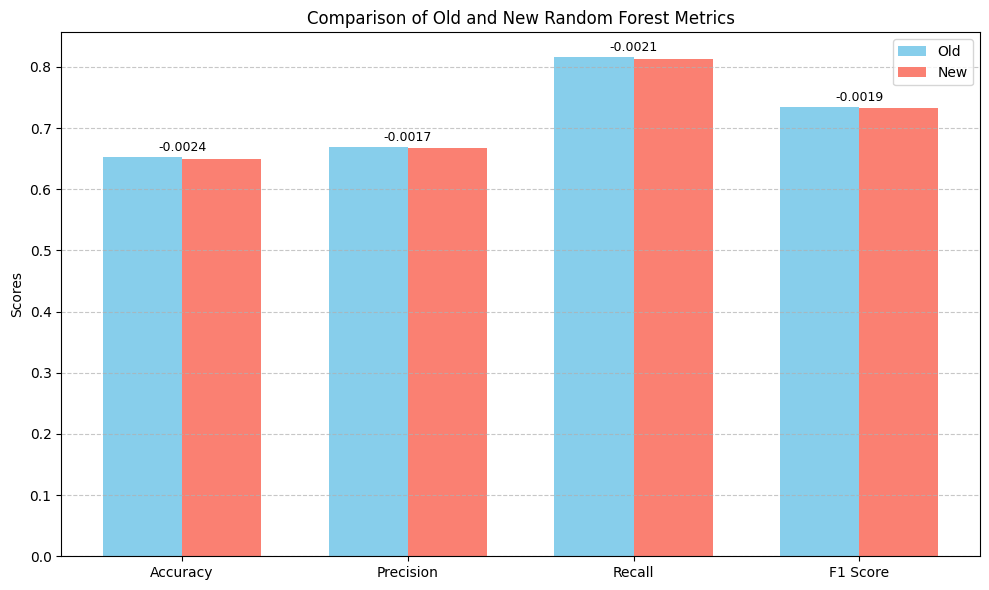

In [36]:
import numpy as np

import matplotlib.pyplot as plt

# 数据
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
old_values = [0.6527, 0.6687, 0.8158, 0.7349]
new_values = [0.6503, 0.6670, 0.8137, 0.7331]
differences = [-0.0024, -0.0017, -0.0021, -0.0019]

# 可视化
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, old_values, width, label='Old', color='skyblue')
plt.bar(x + width/2, new_values, width, label='New', color='salmon')

# 添加差异标注
for i, diff in enumerate(differences):
    plt.text(i, max(old_values[i], new_values[i]) + 0.01, f"{diff:+.4f}", ha='center', fontsize=9)

# 添加标签和标题
plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Comparison of Old and New Random Forest Metrics')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()